# PyDEns Examples

Solving partial differential equations (PDEs) with neural networks using `PyDEns`-framework. 

Here goes the list of working examples:


1. simple first-order ODE in $\mathcal{R}$",
2. poisson equation in $\mathcal{R}^2$",
3. parametric family of ODEs in $\mathcal{R}$",
4. parametric heat-equation with uncertainty in diffusivity in $\mathcal{R}^2 \times \mathcal{R}$",
5. equation with trainable coefficients in $\mathcal{R}$"

## Imports and plotters

In [211]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [212]:
from pydens import Solver, D, V, ConvBlockModel
from pydens import NumpySampler as NS

In [213]:
def plot_loss(loss):
    plt.plot(loss)
    plt.grid()
    plt.xlabel('ITERATION', fontsize=16)
    plt.ylabel('L1-loss', fontsize=16)

In [214]:
def plot_approximation_1d(points, approximation, solution_function, savepath=None,
                          title=None, ylim=None):
    if isinstance(points, torch.Tensor):
        points = points.detach().numpy()
    if isinstance(approximation, torch.Tensor):
        approximation = approximation.detach().numpy()

    plt.plot(points, approximation, label='Neural Network approximation',
             linewidth=5, alpha=0.8)
    plt.plot(points, solution_function(points), label='Known analytical solution',
             linewidth=2)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$\hat{f}(x)$', fontsize=16)
    plt.grid()
    plt.legend(fontsize=12, loc=1)

    if ylim is not None:
        plt.ylim(ylim)

    if title is not None:
      plt.title(title, fontsize=16)

    if savepath is not None:
        plt.savefig(savepath, dpi=300)

In [215]:
def plot_approximation_2d(approximation):
    plt.imshow(approximation)
    plt.colorbar()
    plt.title(r'$\hat{f}(x, y)$', fontsize=16)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$y$', fontsize=16)

In [216]:
def cart_prod(*arrs):
    """ Get array of cartesian tuples from arbitrary number of arrays.
    """
    grids = np.meshgrid(*arrs, indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, len(arrs))

## Simple ODE in $\mathcal{R}$

$$ \frac{d f}{d x} = 2 \pi \cos{[2 \pi x]}, \quad f(0)=0.5. $$

In [217]:
def ode(f, x):
    return D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)

In [218]:
solver = Solver(ode, ndims=1, initial_condition=.5, activation='Tanh')

In [219]:
solver.fit(niters=500, batch_size=400, lr=0.02)

100%|██████████| 500/500 [00:01<00:00, 395.89it/s]


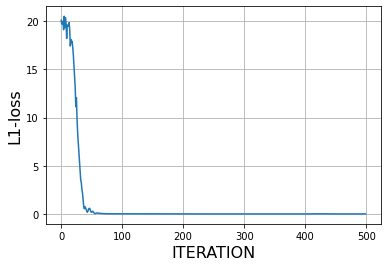

In [220]:
plot_loss(solver.losses)

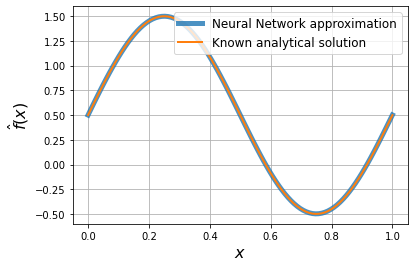

In [221]:
xs = torch.tensor(np.linspace(0, 1, 100)).float()
fs = solver.predict(xs)
plot_approximation_1d(xs, fs, lambda x: np.sin(2 * np.pi * x) + .5)

## Poisson equation in $\mathcal{R}^2$

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 5 \sin(\pi(x + y)); \quad \quad
u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 1. $$

In [222]:
def pde(f, x, y):
    return D(D(f, x), x) + D(D(f, y), y) - 5 * torch.sin(np.pi * (x + y))

In [223]:
solver = Solver(pde, ndims=2, boundary_condition=1,
    model=ConvBlockModel, layout='fafaf', 
    units=[10, 10, 1], activation='Tanh')

In [224]:
solver.fit(niters=300, batch_size=400, lr=0.02)

100%|██████████| 300/300 [00:02<00:00, 113.05it/s]


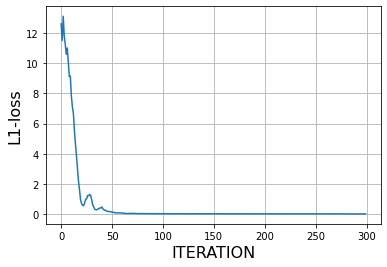

In [225]:
plot_loss(solver.losses[:])

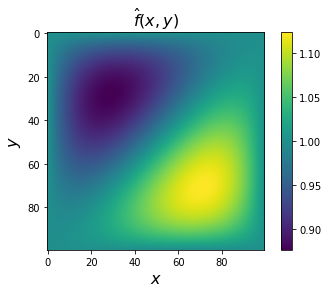

In [226]:
grid = cart_prod(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
approxs = solver.predict(grid[:, 0:1], grid[:, 1:2]).reshape((100, 100))
plot_approximation_2d(approxs)

## Parametric family of ODEs in $\mathcal{R}$

$$ \frac{d f}{d t} = \epsilon \pi \cos{[\epsilon \pi t]},\quad \epsilon \in [1, 5], \quad 
f(0) = 1.  \quad  \quad   \quad  \quad  \quad  $$

In [227]:
def odeparam(f, x, e):
    return D(f, x) - e * np.pi * torch.cos(e * np.pi * x)

In [228]:
solver = Solver(odeparam, ndims=1, initial_condition=2.0, nparams=1)
sampler = NS('u') & NS('u', low=.5, high=5.5)
solver.fit(niters=3500, batch_size=700, sampler=sampler, lr=0.01)

100%|██████████| 3500/3500 [00:13<00:00, 266.81it/s]


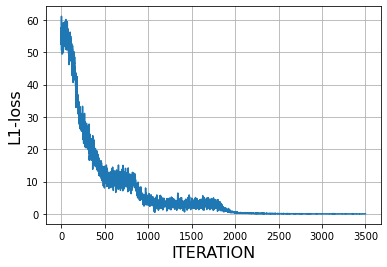

In [229]:
plot_loss(solver.losses[:])

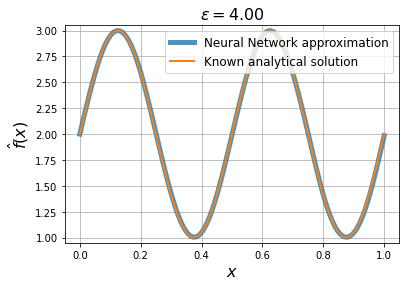

In [230]:
# checking out the solution approximation for fixed epsilon
eps = 4
approxs = solver.predict(xs, eps)

plot_approximation_1d(xs, approxs, 
    lambda x: np.sin(eps * np.pi * x) + 2,
    title=fr'$\varepsilon={eps:03.2f}$', ylim=(0.95, 3.05))

## Parametric heat-equation in $\mathcal{R}^2 \times \mathcal{R}$

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}  - a \frac{\partial u}{\partial t} = 0, \quad a \in [0.1, 4]; \quad u(x, y, t=0) = x y (1 - x) (1 - y). \quad \quad $$

In [231]:
def pde(f, x, y, t, a):
    return D(D(f, x), x) + D(D(f, y), y) - a * D(f, t)

In [232]:
solver = Solver(pde, ndims=3, nparams=1,
    initial_condition=lambda x, y: 10 * x * y * (1 - x) * (1 - y),
    boundary_condition=0, layout='fafaf', units=[30, 40, 1], activation='Sigmoid')
sampler = NS('u', dim=2) & NS('u', low=0, high=.5) &  NS('u', low=.1, high=4)
solver.fit(niters=1000, batch_size=1500, lr=0.005)

100%|██████████| 1000/1000 [00:29<00:00, 34.44it/s]


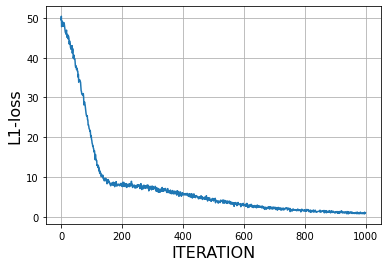

In [233]:
plot_loss(solver.losses[:])

In [234]:
def get_approxs(t=.1, param=1.):
    grid = cart_prod(np.linspace(0, 1, 100),
                     np.linspace(0, 1, 100))
    xs, ys = grid[:, 0:1], grid[:, 1:2]
    return solver.predict(xs, ys, t, param).reshape((100, 100))

* for fixed value of diffusivity($a$) and $t$

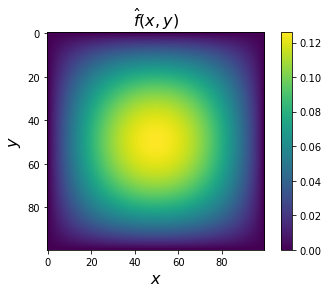

In [235]:
plot_approximation_2d(get_approxs(t=.1, ))

* gather means through time for different values of diffusivity

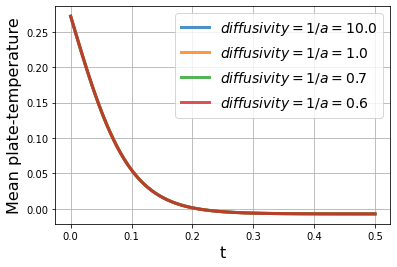

In [236]:
xs = np.linspace(0, .5, 100)
for p in [.1, 1, 1.5, 1.8]:
    plt.plot(xs, [np.mean(get_approxs(t=t, param=p)) for t in xs],
             label=fr'$diffusivity= 1 / a = {1 / p:3.1f}$', linewidth=3, alpha=0.8)
plt.legend(fontsize=14)
plt.xlabel(r't', fontsize=16)
plt.ylabel('Mean plate-temperature', fontsize=16)
plt.grid()

## ODE with trainable coefficients in $\mathcal{R}$

First-order ODE with trainable coefficient:
$$ \frac{d f}{d x} = 2 \pi \cos{[2 \pi x]} + \omega, \quad f(0)=0.5; $$
additional constraint to determine missing coefficient: $$ f(0.5)=0. $$

In [237]:
def odevar(f, x):
    return (D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)
            + V('new_var', data=torch.Tensor([1.0])))

In [238]:
solver = Solver(odevar, ndims=1, initial_condition=1,
    constraints=lambda f, x: f(torch.tensor([0.5])))

* train the model to satisfy the equation

In [239]:
solver.model.freeze_trainable(variables=('new_var',))
solver.fit(niters=200, batch_size=500, lr=0.1)

100%|██████████| 200/200 [00:00<00:00, 333.89it/s]


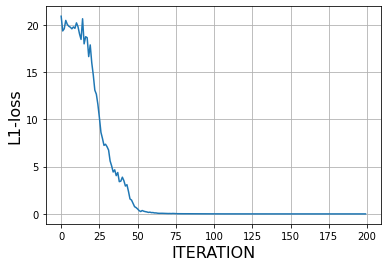

In [240]:
plot_loss(solver.losses)

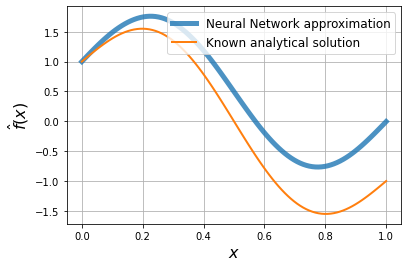

In [241]:
xs = torch.Tensor(np.linspace(0, 1, 100))
approxs = solver.predict(xs)

plot_approximation_1d(xs, approxs, lambda x: np.sin(2 * np.pi * x) + 1 - 2 * x)

* train the variable to satisfy additional constraint

In [242]:
solver.model.unfreeze_trainable(variables=['new_var'])
solver.fit(niters=100, batch_size=100, 
    lr=0.1, loss_terms=['equation', 'constraint_0'])

100%|██████████| 100/100 [00:00<00:00, 310.56it/s]


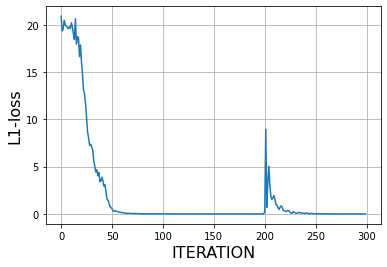

In [243]:
plot_loss(solver.losses)

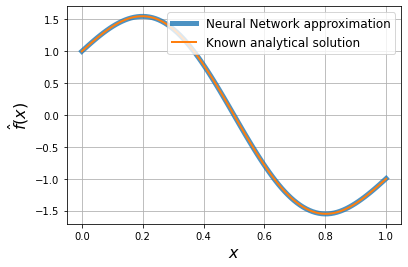

In [244]:
approxs = solver.predict(xs)
plot_approximation_1d(xs, approxs,
    solution_function=lambda x: np.sin(2 * np.pi * x) + 1 - 2 * x)